In [1]:
import numpy as np
import tensorflow as tf

In [2]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#    featurewise_center = True,
#    samplewise_center = True,
#    featurewise_std_normalization = True,
#    samplewise_std_normalization = True
#)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = datagen.flow_from_directory(
    'dataset/train',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_directory(
    'dataset/test',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

Found 25857 images belonging to 7 classes.
Found 6047 images belonging to 7 classes.


In [3]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(160, 160, 3)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=mish),
    tf.keras.layers.Dense(512, activation=mish),
    tf.keras.layers.Dense(1024, activation=mish),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 80, 80, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 80, 80, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                  

In [21]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 100:
        return 0.0001
    elif epoch < 180:
        return 0.00006
    elif epoch < 250:
        return 0.00003

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler(0)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [23]:
with tf.device('/gpu:0'):
    history = model.fit(train_datagen, epochs=250, batch_size=32, validation_data=test_datagen, verbose=1, steps_per_epoch=16, validation_steps=32, callbacks=[scheduler_callback])

Epoch 1/250
16/16 [==============================] - 23s 1s/step - loss: 2.0543 - accuracy: 0.1484 - val_loss: 2.0845 - val_accuracy: 0.0195 - lr: 0.0010
Epoch 2/250
16/16 [==============================] - 22s 1s/step - loss: 2.1780 - accuracy: 0.1504 - val_loss: 1.8639 - val_accuracy: 0.2441 - lr: 0.0010
Epoch 3/250
16/16 [==============================] - 48s 3s/step - loss: 1.9724 - accuracy: 0.1973 - val_loss: 1.8392 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 4/250
16/16 [==============================] - 120s 8s/step - loss: 1.9254 - accuracy: 0.1992 - val_loss: 1.5562 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 5/250
16/16 [==============================] - 75s 5s/step - loss: 1.9092 - accuracy: 0.2070 - val_loss: 1.6535 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 6/250
16/16 [==============================] - 17s 1s/step - loss: 1.8699 - accuracy: 0.2207 - val_loss: 1.8280 - val_accuracy: 0.4082 - lr: 1.0000e-04
Epoch 7/250
16/16 [==============================] - 17s 1s/step - loss

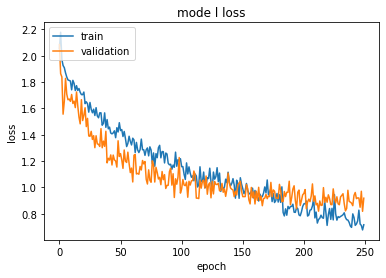

In [24]:
import matplotlib.pyplot as plt

# Save Train result
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mode l loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig2.savefig('history/loss9.jpg')

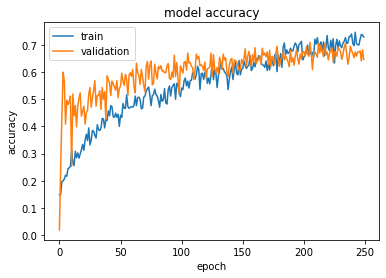

In [25]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig1.savefig('history/accuracy9.jpg')

In [26]:
def myprint(s):
    with open('history/modelsummary9.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)

In [11]:
# Model Validation
eval_hist_train = model.evaluate(train_datagen)
eval_hist_test = model.evaluate(test_datagen)

189/189 [==============================] - 10s 52ms/step - loss: 0.9450 - accuracy: 0.6492


In [12]:
accuracy_eval_train = eval_hist_train[1]
accuracy_eval_test = eval_hist_test[1]

In [13]:
model.save_weights("utils/demo_weight.h5")